In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt

In [31]:
data_dir = '../data/harrypotter'

batch_size = 32
epochs = 8
workers = 0 if os.name == 'nt' else 8

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

Running on device: cuda:0


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[206.70107, 75.16999, 350.255, 241.34943]


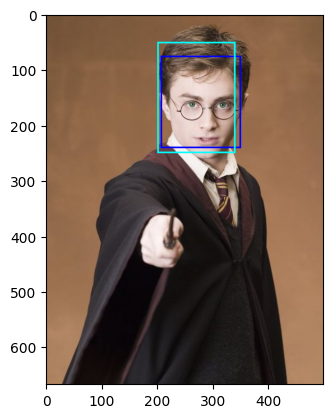

In [35]:
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
# dataset.samples = [
#     (p, p.replace(data_dir, data_dir + '_cropped'))
#         for p, _ in dataset.samples
# ]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)
keep_all=False
save_path='../data/harrypotter/harry'
from PIL import Image, ImageDraw


box=[]
for i, (x, y) in enumerate(loader):
    pil_image = Image.open('../data/harrypotter/harry/1.jpg').convert("RGB")
    
    draw = ImageDraw.Draw(pil_image)
    batch_boxes, batch_probs,batch_points = mtcnn.detect(x,landmarks=True)
    x = batch_boxes[0][0]
    left=x[3] # 바운딩 좌상단 x(left),y(top)
    top=x[1]
    right=x[2] # 바운딩 우하단
    bottom=x[0]
    box=[left,top,right,bottom]
    print(box)
    a=[200, 50, 340, 250]
    left1=a[0] # 바운딩 좌상단 x(left),y(top)
    top1=a[1]
    right1=a[2] # 바운딩 우하단
    bottom1=a[3]
    # print(x[0])
    # print(x[1])
    # print(x[2])
    # print(x[3])
    # print()
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255),width=3)
    draw.rectangle(((left1, top1), (right1, bottom1)), outline=(0, 255, 255),width=3)
    plt.imshow(pil_image)
    plt.show()
    # Extract faces
    # faces = mtcnn.extract(x, batch_boxes, save_path)
    # print(faces)


1208.8313
236.88805
1050.1173
943.5235
342.55923
583.5094
427.40308
781.46814


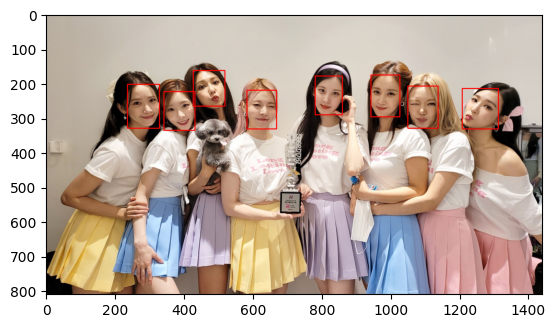

In [30]:
import cv2
from facenet_pytorch.models.mtcnn import MTCNN
import numpy as np
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)


def mtcnn_detect(img: np.ndarray) -> np.ndarray:
    boxes, probs = mtcnn.detect(img)
    for box in boxes:
        x_left = min(box[0], box[2])
        x_right = max(box[0], box[2])
        y_left = min(box[1], box[3])
        y_right = max(box[1], box[3])
        print(x_left)
        img = cv2.rectangle(img, (int(x_left), int(y_left)), (int(x_right), int(y_right)), 
                            (255, 0, 0),2)

    return plt.imshow(img)
img = Image.open('../data/harrypotter/harry/소녀시대.jpg')
img = np.array(img)
mtcnn_detect(img)

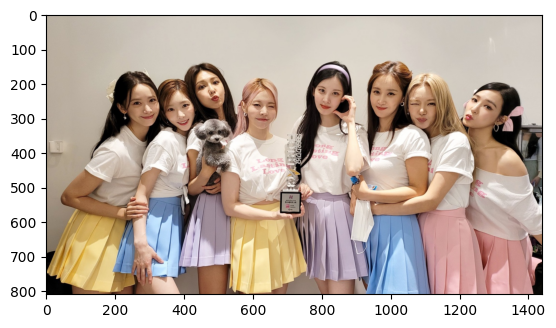

In [6]:
img =plt.imread('../data/harrypotter/harry/소녀시대.jpg')
plt.imshow(img)
plt.show()

 IoU를 파이토치로 구현하기 전에 바운딩 박스의 두 가지 형식을 알아보겠습니다.

 
(1) midpoint
 midpoint 형식의 바운딩 박스는 4개의 변수를 갖습니다. (x1,y1,w,h)
 여기서 (x1,y1)은 바운딩 박스의 중앙점, (w,h)는바운딩 박스의 넓이(w), 높이(h)입니다.

 
(2) corner
 corner 형식의 바운딩 박스는 (x1,y1,x2,y2) 입니다.
 여기서 (x1,y1)은 바운딩 박스의 좌측상단좌표, (x2,y2)는 바운딩 박스의 우측하단좌표를 의미합니다.

In [36]:
print(box)
Iou(box,a)

[206.70107, 75.16999, 350.255, 241.34943]


0.7457384854011323

In [33]:
def Iou(bbox1, bbox2):
    # bbox shape = [x1, y1, x2, y2]
    intersection_x1 = max(bbox1[0], bbox2[0])
    intersection_y1 = max(bbox1[1], bbox2[1])
    intersection_x2 = min(bbox1[2], bbox2[2])
    intersection_y2 = min(bbox1[3], bbox2[3])

    intersection = max(0, intersection_x2-intersection_x1)*max(0, intersection_y2-intersection_y1) 
    box1_area = abs((bbox1[2]-bbox1[0])*(bbox1[3]-bbox1[1]))
    box2_area = abs((bbox2[2]-bbox2[0])*(bbox2[3]-bbox2[1]))   

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [28]:
import torch

def intersection_over_union(boxes_preds, boxes_labels, box_format='corners'):
    '''
    Calculates intersection over union
    
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes  (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes  (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    
    Returns:
        tensor: Intersection over union for all examples
    ''' 
    
    if box_format == 'midpoint':
        box1_x1 = boxes_preds[:,0:1] - boxes_preds[:,2:3] / 2
        box1_y1 = boxes_preds[:,1:2] - boxes_preds[:,3:4] / 2
        box1_x2 = boxes_preds[:,0:1] + boxes_preds[:,2:3] / 2
        box1_y2 = boxes_preds[:,1:2] + boxes_preds[:,3:4] / 2

        box2_x1 = boxes_labels[:,0:1] - boxes_labels[:,2:3] / 2
        box2_y1 = boxes_labels[:,1:2] - boxes_labels[:,3:4] / 2
        box2_x2 = boxes_labels[:,0:1] + boxes_labels[:,2:3] / 2
        box2_y2 = boxes_labels[:,1:2] + boxes_labels[:,3:4] / 2
    
    elif box_format == 'corners':   
        box1_x1 = boxes_preds[:,0:1]
        box1_y1 = boxes_preds[:,1:2]
        box1_x2 = boxes_preds[:,2:3]
        box1_y2 = boxes_preds[:,3:4]

        box2_x1 = boxes_labels[:,0:1]
        box2_y1 = boxes_labels[:,1:2]
        box2_x2 = boxes_labels[:,2:3]
        box2_y2 = boxes_labels[:,3:4]
        
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y1 - box1_y2))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y1 - box2_y2))
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)